## Image

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

import torch

# Ma trận số 1
image_1 = torch.tensor([
    [0, 0, 0, 1, 0, 0, 0],
    [0, 0, 1, 1, 0, 0, 0],
    [0, 0, 0, 1, 0, 0, 0],
    [0, 0, 0, 1, 0, 0, 0],
    [0, 0, 0, 1, 0, 0, 0],
    [0, 0, 0, 1, 0, 0, 0],
    [0, 1, 1, 1, 1, 0, 0],
], dtype=torch.float32).unsqueeze(0).unsqueeze(0)

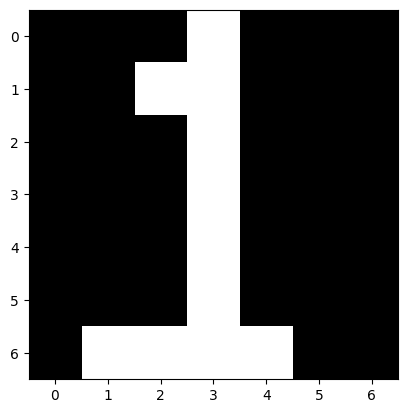

In [2]:
plt.imshow(image_1[0][0], cmap='gray')
plt.show()

In [3]:
# Thiết lập các tham số
timesteps = 10
beta_start, beta_end = 0.0001, 0.02

# Tạo beta schedule
betas = torch.linspace(beta_start, beta_end, timesteps)
alphas = 1 - betas
alphas_cumprod = torch.cumprod(alphas, dim=0)

# Các hằng số
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1 - alphas_cumprod)

In [4]:
import torch.nn as nn

class SimpleDDPM(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Conv2d(1, 1, kernel_size=3, padding=1)
        self.time_embed = nn.Linear(1, 1)
        self.decoder = nn.ConvTranspose2d(1, 1, kernel_size=3, padding=1)

    def forward(self, x, t):
        x_encoded = self.encoder(x)
        t_embed = self.time_embed(t.unsqueeze(-1).float())  # [B, 1]
        t_embed = t_embed.view(-1, 1, 1, 1)
        out = x_encoded + t_embed
        return self.decoder(out)

In [5]:
# Khởi tạo model
model = SimpleDDPM()

# Chuẩn bị optimizer và loss function
optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

In [6]:
x0 = image_1

In [7]:
# Forward diffusion (thêm nhiễu)
trajectories = [x0]
for t in range(timesteps):
    # Tạo nhiễu
    eps = torch.randn_like(x0)

    # Thêm nhiễu vào ảnh
    x_t = (
        sqrt_alphas_cumprod[t] * x0 +
        sqrt_one_minus_alphas_cumprod[t] * eps
    )

    trajectories.append(x_t)
trajectories

[tensor([[[[0., 0., 0., 1., 0., 0., 0.],
           [0., 0., 1., 1., 0., 0., 0.],
           [0., 0., 0., 1., 0., 0., 0.],
           [0., 0., 0., 1., 0., 0., 0.],
           [0., 0., 0., 1., 0., 0., 0.],
           [0., 0., 0., 1., 0., 0., 0.],
           [0., 1., 1., 1., 1., 0., 0.]]]]),
 tensor([[[[-8.5519e-03,  7.0369e-03, -7.0953e-03,  1.0161e+00, -1.8990e-02,
            -1.2619e-03, -6.6642e-03],
           [ 1.5399e-02,  6.3570e-03,  9.7009e-01,  1.0148e+00,  4.4543e-03,
            -6.6538e-03,  3.0491e-03],
           [-4.9692e-03,  9.0370e-03,  1.6735e-03,  1.0030e+00, -1.2155e-02,
             8.6780e-03,  2.8085e-03],
           [ 5.5555e-03,  1.2066e-04,  2.7896e-03,  9.8601e-01, -2.3518e-03,
            -2.2960e-02,  8.8142e-03],
           [ 1.1393e-03,  3.4714e-04,  7.3063e-03,  1.0052e+00,  1.0509e-02,
            -2.8229e-03, -1.3664e-02],
           [-8.0844e-03,  5.8134e-03,  1.1376e-03,  1.0095e+00, -1.2019e-02,
             5.0799e-04, -8.7661e-04],
           [ 

In [8]:
# Huấn luyện model
losses = []
steps = 5000
model.train()

for step in range(steps):
    # Chọn timestep ngẫu nhiên
    t = torch.randint(0, timesteps, (1,))

    # Tạo nhiễu
    eps = torch.randn_like(x0)

    # Thêm nhiễu vào ảnh
    x_t = (
        sqrt_alphas_cumprod[t] * x0 +
        sqrt_one_minus_alphas_cumprod[t] * eps
    )

    # Dự đoán nhiễu
    pred_eps = model(x_t, t)

    # Tính loss
    loss = loss_fn(pred_eps, eps)

    # Cập nhật model
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.item())

    # In loss định kỳ
    if step % 500 == 0:
        print(f"Step {step}, Loss: {loss.item():.6f}")

Step 0, Loss: 1.989411
Step 500, Loss: 1.174556
Step 1000, Loss: 0.864357
Step 1500, Loss: 0.609248
Step 2000, Loss: 0.763447
Step 2500, Loss: 1.095676
Step 3000, Loss: 0.519326
Step 3500, Loss: 0.438678
Step 4000, Loss: 0.883178
Step 4500, Loss: 0.611497


In [9]:
# Reverse process (khôi phục ảnh)
model.eval()
x_t = trajectories[-1]  # Ảnh nhiễu cuối cùng
reverse_trajectory = [x_t]

with torch.no_grad():
    for t in reversed(range(timesteps)):
        # Dự đoán nhiễu
        eps_theta = model(x_t, torch.tensor([t]))

        # Tính toán các tham số
        alpha_t = alphas[t]
        alpha_bar_t = alphas_cumprod[t]
        beta_t = betas[t]

        # Compute coefficients
        coef1 = 1 / torch.sqrt(alpha_t)
        coef2 = (1 - alpha_t) / torch.sqrt(1 - alpha_bar_t)

        # Dự đoán x_0
        x_0_pred = coef1 * (x_t - coef2 * eps_theta)

        # Giới hạn x_0_pred
        x_0_pred = torch.clamp(x_0_pred, min=0, max=1)

        # Tính toán mean
        if t > 0:
            noise = torch.randn_like(x_t)
            sigma = torch.sqrt(beta_t)
            x_t = coef1 * (x_t - coef2 * eps_theta) + sigma * noise
        else:
            x_t = x_0_pred

        reverse_trajectory.append(x_t)

In [10]:
reverse_trajectory

[tensor([[[[ 0.1848,  0.5156,  0.0174,  1.1112, -0.4084, -0.6592,  0.2026],
           [-0.1525,  0.1490,  1.1636,  1.1848,  0.0427, -0.0450, -0.0534],
           [ 0.1661,  0.0611,  0.0562,  0.6382,  0.3245, -0.0545,  0.1379],
           [-0.0572,  0.0763,  0.1210,  1.1835,  0.1450, -0.1186, -0.0565],
           [ 0.1614,  0.0388, -0.6127,  0.9689,  0.0246,  0.1202,  0.1718],
           [-0.2034, -0.3653,  0.4438,  1.0224, -0.2245,  0.2132,  0.1360],
           [ 0.2607,  0.5990,  0.8253,  0.9953,  1.2226,  0.0316, -0.0342]]]]),
 tensor([[[[ 1.6075e-01,  1.7776e-01,  7.1416e-03,  1.5129e+00, -3.1096e-01,
            -5.0459e-01,  4.6570e-02],
           [-9.4662e-02,  1.7270e-01,  1.0813e+00,  1.0881e+00, -4.7686e-02,
            -1.9613e-01, -1.4829e-01],
           [ 1.3556e-01,  4.4876e-01,  2.1805e-01,  6.0713e-01,  4.0278e-01,
             1.5277e-01,  1.3522e-01],
           [-5.1241e-02, -2.9948e-02,  3.3461e-01,  1.1356e+00,  1.9732e-01,
            -3.2256e-01, -1.1965e-01],


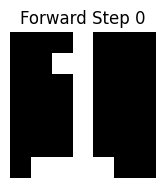

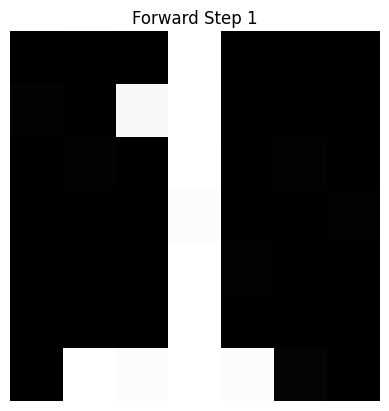

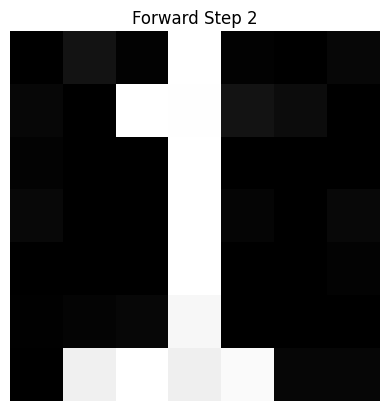

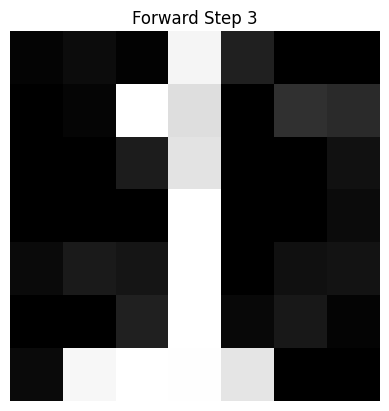

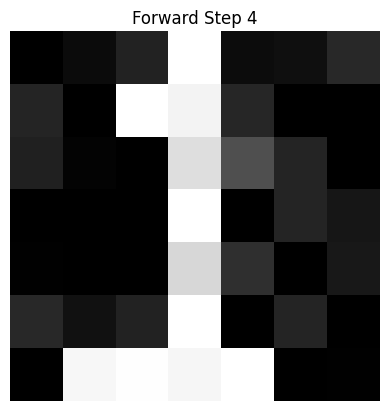

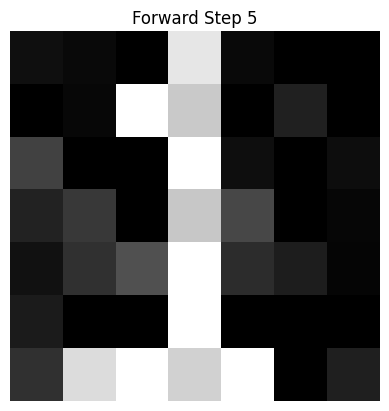

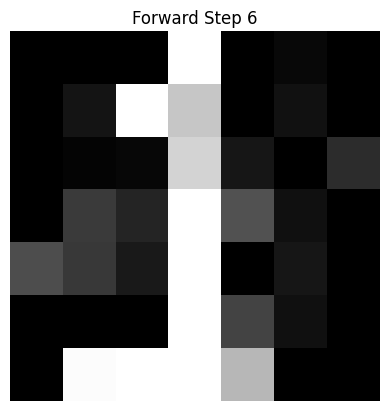

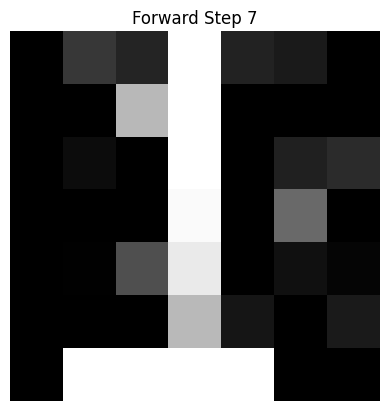

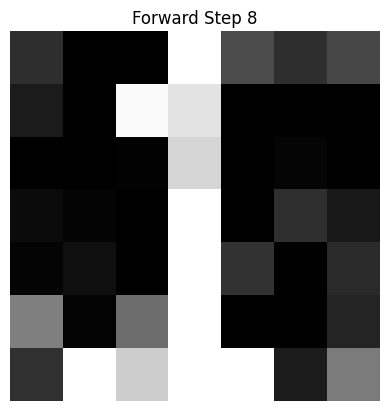

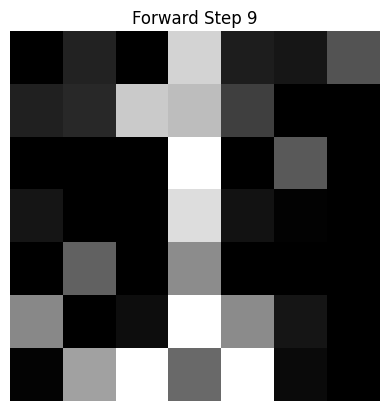

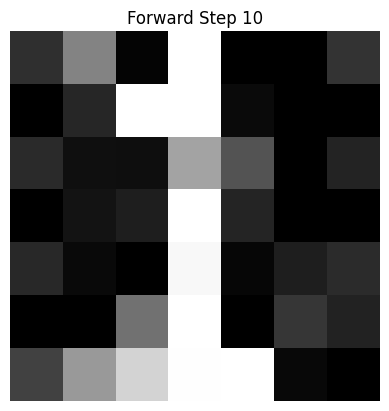

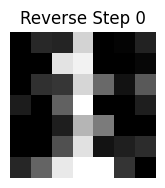

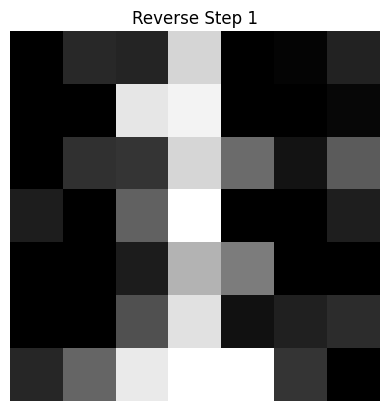

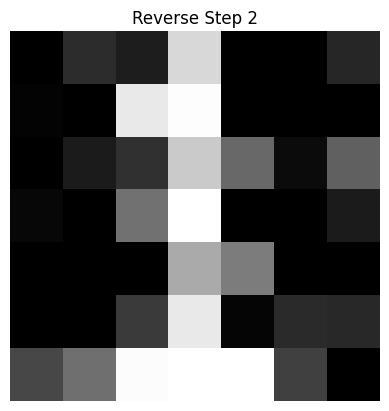

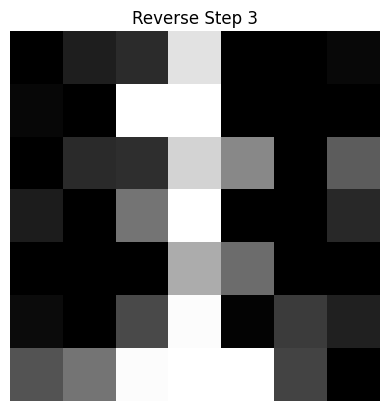

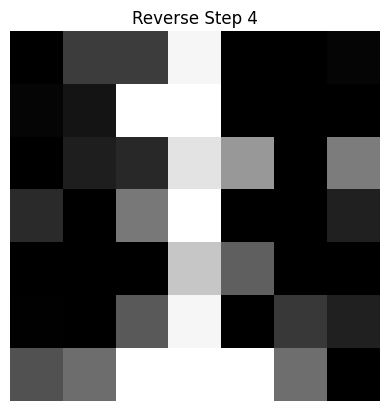

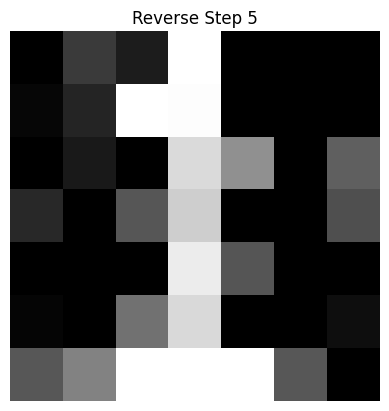

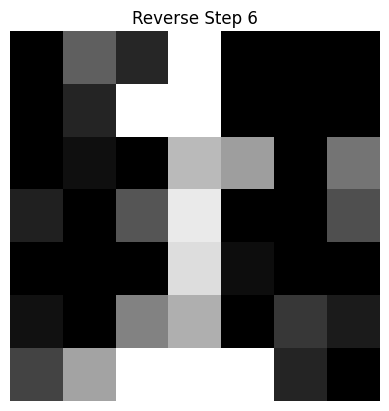

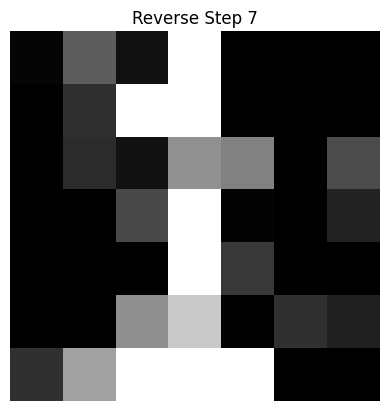

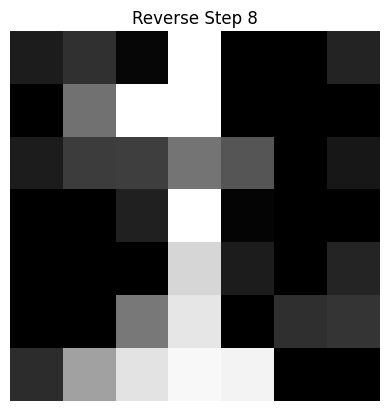

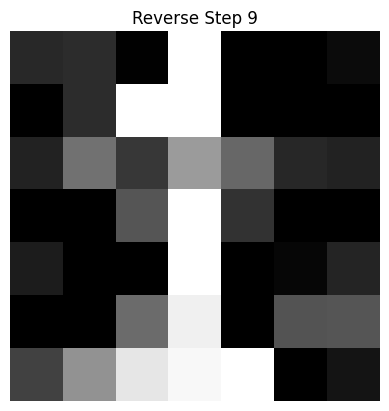

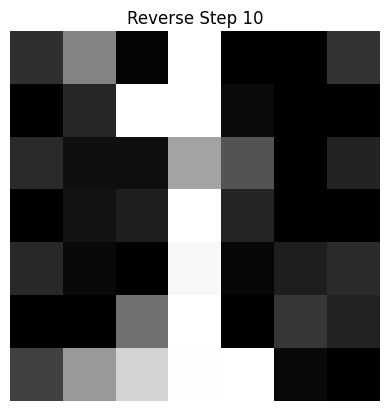

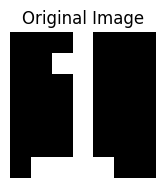

In [11]:
# Forward trajectory
plt.subplot(1, 3, 1)
for i, img in enumerate(trajectories):
    plt.imshow(img.squeeze(), cmap='gray', vmin=0, vmax=1)
    plt.title(f'Forward Step {i}')
    plt.axis('off')
    plt.show()

# Reverse trajectory
plt.subplot(1, 3, 2)
for i, img in enumerate(list(reversed(reverse_trajectory))):
    plt.imshow(img.squeeze(), cmap='gray', vmin=0, vmax=1)
    plt.title(f'Reverse Step {i}')
    plt.axis('off')
    plt.show()

# So sánh ảnh gốc và ảnh khôi phục
plt.subplot(1, 3, 3)
plt.imshow(x0.squeeze(), cmap='gray', vmin=0, vmax=1)
plt.title('Original Image')
plt.axis('off')
plt.show()